## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random as rn
import numpy as np
import json
import cv2
import os

In [2]:
pd.options.mode.chained_assignment = None

from IPython.core.interactiveshell import InteractiveShell   
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
os.listdir('D:/Study material/Datasets/cassava-leaf-disease-classification')

# tfrecords is a tensorflow file format for storing the images
# json files are mainly used for data transfer (mostly text)
# csv files contains image file names and their corresponding labels

['.ipynb_checkpoints',
 'Cassava-Leaf-Disease-Classification.ipynb',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'test_images',
 'test_tfrecords',
 'train.csv',
 'train_images',
 'train_tfrecords']

In [4]:
# Reading json files to know different classes of possible leaf disease

with open('D:/Study material/Datasets/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    print(json.loads(f.read()))

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [5]:
img_lbl = pd.read_csv('D:/Study material/Datasets/cassava-leaf-disease-classification/train.csv')
img_lbl.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
# Removing Duplicate images as mentioned in the discussion ('1562043567.jpg', '3551135685.jpg', '2252529694.jpg' are duplicate)

img_lbl=img_lbl[~img_lbl['image_id'].isin(['1562043567.jpg', '3551135685.jpg', '2252529694.jpg'])]

In [7]:
img_lbl['label'].value_counts()

# Cassava Mosaic Disease (CMD) is the most spread leaf disease.
# Cassava Bacterial Blight (CBB) is the least spread leaf disease.

3    13158
4     2575
2     2386
1     2189
0     1086
Name: label, dtype: int64

In [8]:
# importing some random images

X=[]   # variable to store leaf images
Z=[]   # variable to store leaf diseases

for img, dseas in tqdm(img_lbl.sample(9).values):
    image=cv2.imread('D:/Study material/Datasets/cassava-leaf-disease-classification/train_images/{}'.format(img),
                     cv2.IMREAD_COLOR)
    image=cv2.resize(image,(600,600))
    X.append(image)    # Appending the images into X
    Z.append(dseas)    # Appending the image labels into Z

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 65.40it/s]


Text(0.5, 1.0, 'Disease Class : 4')

Text(0.5, 1.0, 'Disease Class : 1')

Text(0.5, 1.0, 'Disease Class : 2')

Text(0.5, 1.0, 'Disease Class : 0')

Text(0.5, 1.0, 'Disease Class : 3')

Text(0.5, 1.0, 'Disease Class : 1')

Text(0.5, 1.0, 'Disease Class : 3')

Text(0.5, 1.0, 'Disease Class : 3')

Text(0.5, 1.0, 'Disease Class : 1')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

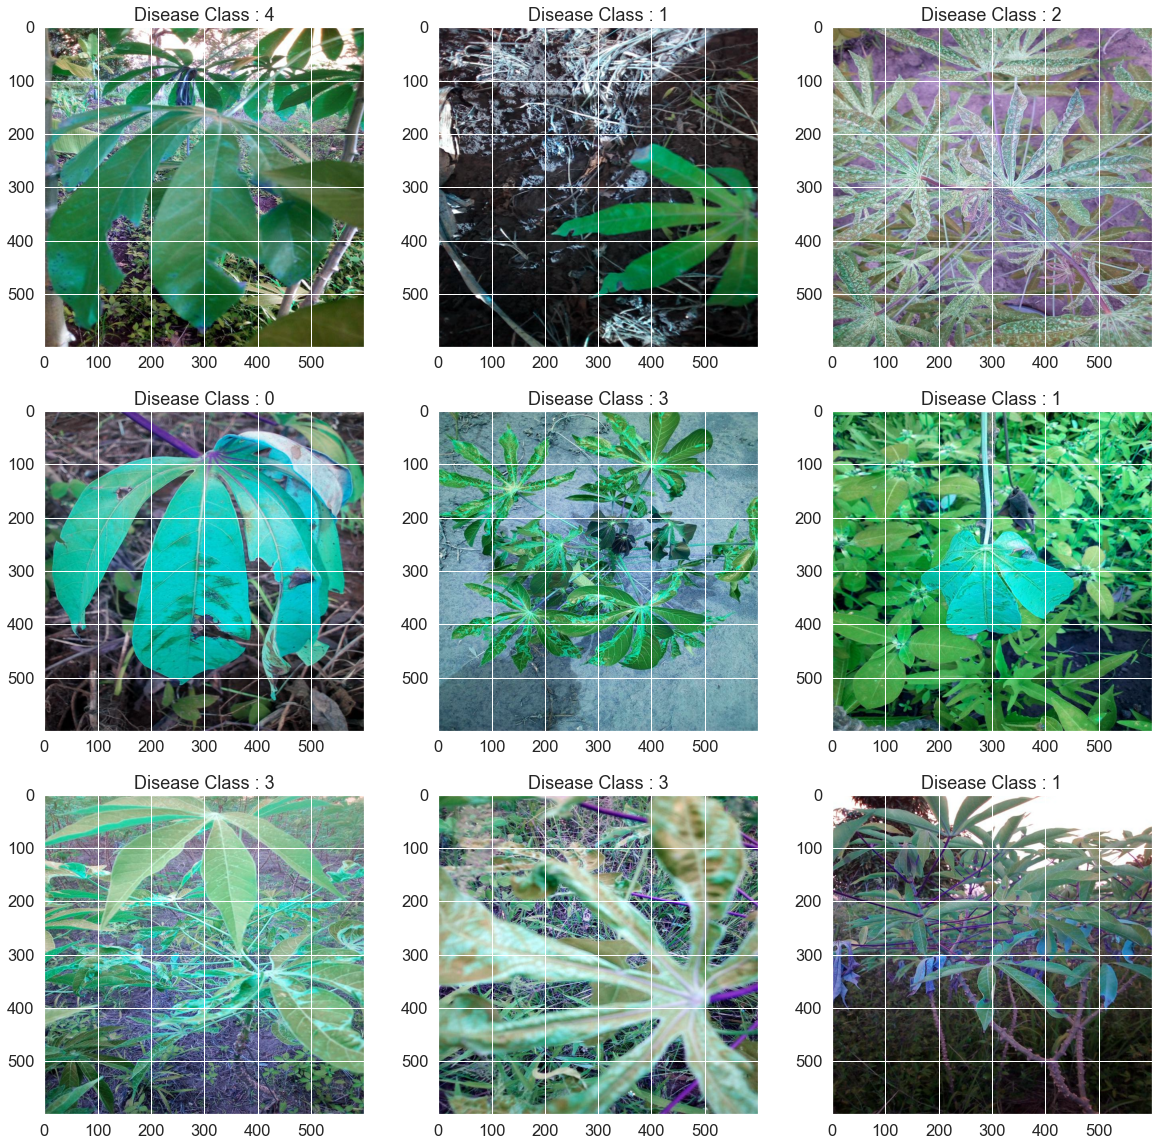

In [10]:
fig, ax=plt.subplots(3,3)
fig.set_size_inches(20,20)
l=0
for row in range(3):    
    for col in range(3):
        ax[row,col].imshow(X[l])
        ax[row,col].set_title('Disease Class : '+str(Z[l]))
        l=l+1

plt.tight_layout
sns.set(font_scale=1.5)

In [11]:
# Splitting data into train andkerasdation

from sklearn.model_selection import train_test_split
train,validation = train_test_split(img_lbl,test_size=0.2,shuffle=True,stratify=img_lbl['label'])

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Flatten,Dropout
from tensorflow.keras.applications import EfficientNetB3

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Imagedatagenerator for training
datagen_trng = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                  rotation_range=30,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  shear_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# label should be converted to string to be used
train['label']=train['label'].astype('str')                        

# Augmenting Images for training
train_datagen=datagen_trng.flow_from_dataframe(dataframe=train,
                                        directory='D:/Study material/Datasets/cassava-leaf-disease-classification/train_images',
                                        x_col="image_id",
                                        y_col="label",
                                        color_mode="rgb",
                                        target_size=(420,420),
                                        batch_size=4,
                                        seed=42,
                                        class_mode="categorical")

Found 17115 validated image filenames belonging to 5 classes.


In [14]:
# Imagedatagenerator for validation
datagen_valid = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# label should be converted to string to be used
validation['label']=validation['label'].astype('str')

# Augmenting Images for validating
valid_datagen=datagen_valid.flow_from_dataframe(dataframe=validation,
                                        directory='D:/Study material/Datasets/cassava-leaf-disease-classification/train_images',
                                        x_col='image_id',
                                        y_col="label",
                                        color_mode="rgb",
                                        target_size=(420,420),
                                        batch_size=4,
                                        seed=42,
                                        class_mode="categorical")

Found 4279 validated image filenames belonging to 5 classes.


In [15]:
# Defining model

model=Sequential()
model.add(EfficientNetB3(include_top=False,weights='imagenet',input_shape=(420,420,3)))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5,activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 14, 14, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [16]:
# Defining callbacks

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(monitor='val_categorical_accuracy',
                         min_delta=0.002,
                         patience=3,
                         mode='max',
                         verbose=1,
                         restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_categorical_accuracy',
                            patience=2,
                            factor=0.1,
                            mode='max',
                            min_lr=1e-6,
                            verbose=1)

In [17]:
model.fit(train_datagen,
          batch_size=train_datagen.n//train_datagen.batch_size,
          epochs=25,verbose=1,shuffle=True,
          validation_data=valid_datagen,
          callbacks=[early_stop,reduce_lr])

Epoch 1/25
4279/4279 [==============================] - 1432s 329ms/step - loss: 1.0550 - categorical_accuracy: 0.6249 - val_loss: 0.8843 - val_categorical_accuracy: 0.6726
Epoch 2/25
4279/4279 [==============================] - 1249s 292ms/step - loss: 0.9315 - categorical_accuracy: 0.6635 - val_loss: 1.0518 - val_categorical_accuracy: 0.6001
Epoch 3/25
4279/4279 [==============================] - 1253s 293ms/step - loss: 0.8357 - categorical_accuracy: 0.6976 - val_loss: 0.8147 - val_categorical_accuracy: 0.6836
Epoch 4/25
4279/4279 [==============================] - 1249s 292ms/step - loss: 0.7611 - categorical_accuracy: 0.7216 - val_loss: 0.7129 - val_categorical_accuracy: 0.7513
Epoch 5/25
4279/4279 [==============================] - 1248s 292ms/step - loss: 0.7261 - categorical_accuracy: 0.7498 - val_loss: 0.6285 - val_categorical_accuracy: 0.7869
Epoch 6/25
4279/4279 [==============================] - 1248s 292ms/step - loss: 0.6931 - categorical_accuracy: 0.7609 - val_loss: 0.66

## Evaluating our model

In [18]:
accuracy=model.evaluate(valid_datagen,verbose=1)
print('Validation accuracy: ',accuracy[1])                 # model.evaluate will give two outputs, loss and accuracy.

1070/1070 [==============================] - 80s 75ms/step - loss: 0.4933 - categorical_accuracy: 0.8469
Validation accuracy:  0.8469268679618835


# Hyperparameter Tunning using RandomSearch

In [19]:
def model_optimse(hp):
    model_hpt=Sequential()
    model_hpt.add(EfficientNetB3(include_top=False,weights='imagenet',input_shape=(420,420,3)))
    model_hpt.add(GlobalAveragePooling2D())
    for i in range(hp.Int('layers',1,5)):
        model_hpt.add(Dense(units=hp.Int('Neurons_in_layer_'+str(i),min_value=32,max_value=512,step=32),
                            activation=hp.Choice('activation_funct',['relu','sigmoid'])))
    model_hpt.add(Dense(5,activation='softmax'))
    
    model_hpt.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=hp.Choice('lrn_rate',values=[1e-4,3e-5,7e-5,1e-5])),
                      loss=tf.keras.losses.CategoricalCrossentropy(),metrics=tf.keras.metrics.CategoricalAccuracy())
    
    return model_hpt

In [20]:
from kerastuner.tuners import RandomSearch

hpt_tuner=RandomSearch(model_optimse,
                       max_trials=20,
                       objective='val_loss',
                       project_name='Rdm_src_HPT',
                       directory='D:/Study material/Datasets/cassava-leaf-disease-classification')

In [21]:
hpt_tuner.search(train_datagen,
                 batch_size=train_datagen.n//train_datagen.batch_size,
                 epochs=2,
                 validation_data=valid_datagen)

Trial 20 Complete [00h 41m 36s]
val_loss: 1.0975391864776611

Best val_loss So Far: 1.0688121318817139
Total elapsed time: 15h 15m 56s
INFO:tensorflow:Oracle triggered exit


As we can see, the best validation loass obtained after RandomSearch is 1.069 which is greater than the validation loss obtained in our first model training. So, we'll not use the model after RandomSearch. Saving our first model for deployment.

In [25]:
model.save('cassava_leaf.h5')